In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as em
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from sklearn.cluster import OPTICS, KMeans
from scipy import stats
from tqdm import trange
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import dask
from scipy.stats import poisson
from sklearn.metrics import adjusted_rand_score
from daskify import Daskified
from label_axes import label_axes
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [3]:
unit_usrt_j = np.concatenate((unit_usrt1[good_indexes], unit_usrt2[good_indexes], unit_usrt3[good_indexes]), axis=0)
mean_usrt1 = np.array([[i.mean() for i in j] for j in unit_usrt1[good_indexes]])
mean_usrt2 = np.array([[i.mean() for i in j] for j in unit_usrt2[good_indexes]])
mean_usrt3 = np.array([[i.mean() for i in j] for j in unit_usrt3[good_indexes]])
mean_all_usrt = np.concatenate((mean_usrt1, mean_usrt2, mean_usrt3), axis=0)
norm_mean_all_usrt = (mean_all_usrt - np.min(mean_all_usrt, axis=-1)[:, np.newaxis])/(np.max(mean_all_usrt, axis=-1)[:, np.newaxis] - np.min(mean_all_usrt, axis=-1)[: ,np.newaxis])

In [4]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Fig4/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Fig4/230320_conc_models1.pkl', 'rb')).load()



In [5]:
bins1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1]).mean(axis=1)
bins2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2]).mean(axis=1)
bins3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3]).mean(axis=1)

all_preds = [i.pred_resp for i in diff_models1] + [i.pred_resp for i in diff_models2] + [i.pred_resp for i in diff_models3]
all_trues = [i.true_resp for i in diff_models1] + [i.true_resp for i in diff_models2] + [i.true_resp for i in diff_models3]


In [6]:
pca1 = PCA(n_components=9)
fit_bins1 = pca1.fit_transform(bins1)
fit_1_pc12 = deepcopy(fit_bins1)
fit_1_pc12[:, 2:] = 0
bins_1_pc12 = pca1.inverse_transform(fit_1_pc12)


pca2 = PCA(n_components=9)
fit_bins2 = pca2.fit_transform(bins2)
fit_2_pc12 = fit_bins2.copy()
fit_2_pc12[:, 2:] = 0
bins_2_pc12 = pca2.inverse_transform(fit_2_pc12)

pca3 = PCA(n_components=9)
fit_bins3 = pca3.fit_transform(bins3)
fit_3_pc12 = fit_bins3.copy()
fit_3_pc12[:, 2:] = 0
bins_3_pc12 = pca3.inverse_transform(fit_3_pc12)

pca_all = PCA(n_components=9)
all_bins = np.concatenate([bins1 , bins2 , bins3], axis=0)
fit_bins_all = pca_all.fit_transform(all_bins)
fit_all_pc12 = fit_bins_all.copy()
fit_all_pc12[:, 2:] = 0
bins_all_pc12 = pca_all.inverse_transform(fit_all_pc12)



In [7]:

all_normed = []
for index in trange(100):
    first_pass_bins = np.array([i.training_opts[index].x[:-1] for i in diff_models1])
    threshes = np.array([i.training_opts[index].x[-1] for i in diff_models1])
    pca = PCA(n_components=9)

    all_fit_errors = []
    all_pred_resps = []
    for pcs in range(0, 10):
        pcad_bins = pca.fit_transform(first_pass_bins)
        pcad_bins[:, pcs:] = 0
        pcad_bins = pca.inverse_transform(pcad_bins)
        [model.fit(W=i.tolist() + [j]) for model, i, j in zip(diff_models1, pcad_bins, threshes)];
        pred_resps = [i.pred_resp for i in diff_models1]
        all_pred_resps.append(pred_resps)
        fit_errors = [np.sum((i.X_test_avg[index] - j)**2) for i, j in zip(diff_models1, pred_resps)]
        all_fit_errors.append(fit_errors)
    all_fit_errors = np.array(all_fit_errors)
    all_pred_resps = np.array(all_pred_resps)
    normed =( all_fit_errors - all_fit_errors.min(axis=0)) / (all_fit_errors.max(axis=0) - all_fit_errors.min(axis=0))
    # for i in normed.T:
    #     plt.plot(i, alpha=0.5, color='lightgray')
    # plt.plot(normed.mean(axis=1))
    # plt.xlabel('Number of PCs')
    # plt.ylabel('Normalized Fit Error')
    all_normed.append(normed)


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Text(0.5, 1.0, 'All splits')

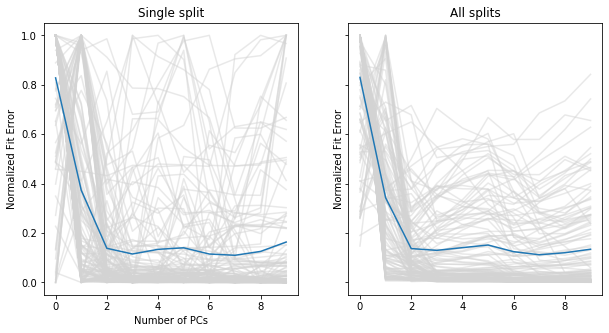

In [8]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for i in all_normed[0].T:
    ax[0].plot(i, alpha=0.5, color='lightgray')
ax[0].plot(all_normed[0].mean(axis=-1))
ax[0].set_xlabel('Number of PCs')
ax[0].set_ylabel('Normalized Fit Error')

mean_normed = np.array(all_normed).mean(axis=0)
for i in mean_normed.T:
    ax[1].plot(i, alpha=0.5, color='lightgray')
ax[1].plot(mean_normed.mean(axis=-1))
#ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('Normalized Fit Error')
ax[0].set_title('Single split')
ax[1].set_title('All splits')

Text(0, 0.5, 'Absolute correlation')

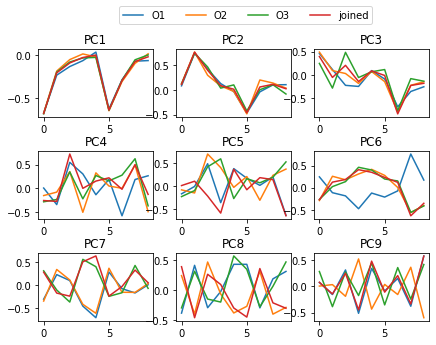

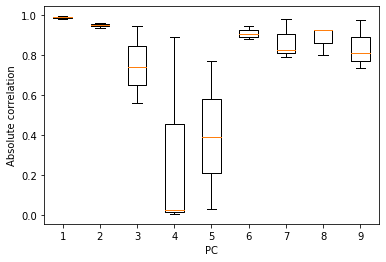

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(7, 5))
fig.subplots_adjust(hspace=0.5)
axs = ax.ravel()
corrs = []
for i in range(9):
    
    axs[i].plot(pca1.components_[i], label='O1')
    axs[i].plot(pca2.components_[i], label='O2')
    axs[i].plot(pca3.components_[i], label='O3')
    axs[i].plot(pca_all.components_[i], label='joined')
    axs[i].set_title('PC{}'.format(i+1))
    flat_triag = np.triu(np.corrcoef([pca1.components_[i], pca2.components_[i], pca3.components_[i]]), 1).flatten()
    flat_triag = flat_triag[flat_triag != 0]
    corrs.append(flat_triag)
axs[1].legend(ncol=4, bbox_to_anchor=(1.75, 1.7))
plt.figure()
plt.boxplot(np.abs(corrs).T);
plt.xlabel('PC')
plt.ylabel('Absolute correlation')

['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray

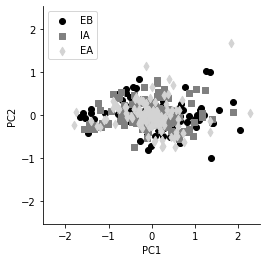

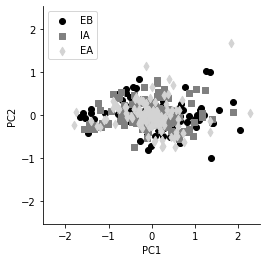

In [10]:
odour_grays = ['k', 'gray', 'lightgray']
cs = [i for i in odour_grays for j in range(130)]
markers = ['o', 's', 'd']
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
print(cs)
plt.scatter(fit_bins_all[:130, 0], fit_bins_all[:130, 1], c='k', label='EB', marker=markers[0])
plt.scatter(fit_bins_all[130:260, 0], fit_bins_all[130:260, 1], c='gray', label='IA', marker=markers[1])
plt.scatter(fit_bins_all[260:, 0], fit_bins_all[260:, 1], c='lightgray', label='EA', marker=markers[2])
plt.legend()
#plt.scatter(fit_bins_all[:, 0], fit_bins_all[:, 1], c=cs, label='All', marker=marker)
xlims = ax.get_xlim()
ylims = ax.get_ylim()
max_lim = np.max(abs(np.concatenate([xlims, ylims])))
ax.set_ylim(-max_lim, max_lim)
ax.set_xlim(-max_lim, max_lim)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

def scatter_pcs(ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
    plt.scatter(fit_bins_all[:130, 0], fit_bins_all[:130, 1], c='k', label='EB', marker=markers[0])
    plt.scatter(fit_bins_all[130:260, 0], fit_bins_all[130:260, 1], c='gray', label='IA', marker=markers[1])
    plt.scatter(fit_bins_all[260:, 0], fit_bins_all[260:, 1], c='lightgray', label='EA', marker=markers[2])
    plt.legend()
    #plt.scatter(fit_bins_all[:, 0], fit_bins_all[:, 1], c=cs, label='All', marker=marker)
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    max_lim = np.max(abs(np.concatenate([xlims, ylims])))
    ax.set_ylim(-max_lim, max_lim)
    ax.set_xlim(-max_lim, max_lim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    return ax
scatter_pcs()

In [11]:
pc1_exp_decay = np.abs([i - np.median(fit_bins_all[:, 0]) for i in fit_bins_all[:, 0]]).mean()
pc2_exp_decay = np.abs([i - np.median(fit_bins_all[:, 1]) for i in fit_bins_all[:, 1]]).mean()
rand1 = np.random.laplace(0, pc1_exp_decay, 10000)
rand2 = np.random.laplace(0, pc2_exp_decay, 10000)

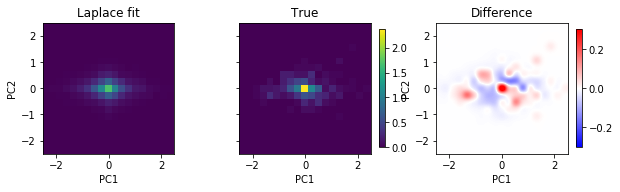

In [12]:
def plot_heatmaps(gs):
    sub_gs = gs.subgridspec(1, 3)

    fig = plt.gcf()
    ax = [fig.add_subplot(sub_gs[i]) for i in range(3)]
    
    h, x, y, p  = ax[0].hist2d(rand1, rand2, bins=[np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20)], density=True);

    h1, x1, y1, p1 = ax[1].hist2d(fit_bins_all[:, 0], fit_bins_all[:, 1], bins=[np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20)], density=True);

    max_h = np.max([np.max(h), np.max(h1)])
    p1.set_clim(0, max_h)
    p.set_clim(0, max_h)
    plt.draw()

    ax[0].set_aspect('equal') 
    ax[1].set_aspect('equal')
    vmax =0.3 #¢np.max(abs(h1-h))/2
    im = ax[2].imshow(np.array(h1-h).T, cmap='bwr', vmax=vmax, vmin=-vmax, extent=[-2.5, 2.5, -2.5, 2.5], interpolation='gaussian', origin='lower')
    plt.colorbar(ax=ax[1], mappable=p1, shrink=0.72)
    plt.colorbar(ax=ax[2], mappable=im, shrink=0.72)
    init_ax_pos = ax[0].get_position()
    ax[0].set_position([init_ax_pos.x0, ax[1].get_position().y0, ax[1].get_position().width,  ax[1].get_position().height])
    ax[0].set_title('Laplace fit')
    ax[1].set_title('True')
    ax[2].set_title('Difference')
    ax[1].set_yticklabels([])
    ax[0].set_ylabel('PC2')
    ax[0].set_xlabel('PC1')
    ax[1].set_xlabel('PC1')
    ax[2].set_xlabel('PC1')
    ax[2].set_ylabel('PC2')
    return ax

fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(1, 1)
plot_heatmaps(gs[0])

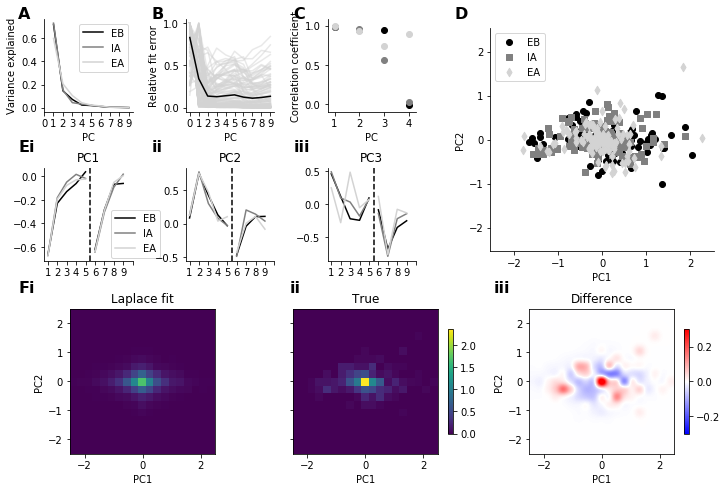

In [14]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(5, 5, hspace=1, wspace=1)
sub_gs = gs[:3, :3].subgridspec(2, 3, wspace=0.6, hspace=0.6)
pc_var_ax = fig.add_subplot(sub_gs[0, 0])
pc_var_ax.plot(range(1, 10), pca1.explained_variance_ratio_, label='EB', color=odour_grays[0])
pc_var_ax.plot(range(1, 10), pca2.explained_variance_ratio_, label='IA', color=odour_grays[1])
pc_var_ax.plot(range(1, 10), pca3.explained_variance_ratio_, label='EA', color=odour_grays[2])
pc_var_ax.set_ylabel('Variance explained')
pc_var_ax.set_xlabel('PC')
pc_var_ax.spines['right'].set_visible(False)
pc_var_ax.spines['top'].set_visible(False)
pc_var_ax.set_xticks(range(0, 10))
pc_var_ax.legend()

pc_error_ax = fig.add_subplot(sub_gs[0, 1])
mean_normed = np.array(all_normed).mean(axis=0)
for i in mean_normed.T:
    pc_error_ax.plot(i, alpha=0.5, color='lightgray')
pc_error_ax.plot(mean_normed.mean(axis=-1), color='k')
pc_error_ax.spines['right'].set_visible(False)
pc_error_ax.spines['top'].set_visible(False)
pc_error_ax.set_ylabel('Relative fit error')
pc_error_ax.set_xlabel('PC')
pc_error_ax.set_xticks(range(0, 10))

corr_ax = fig.add_subplot(sub_gs[0, 2])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 0], color=odour_grays[0])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 1], color=odour_grays[1])
corr_ax.scatter(range(1, 5), np.array(corrs)[:4, 2], color=odour_grays[2])
corr_ax.set_ylabel('Correlation coefficient')
corr_ax.set_xlabel('PC')
corr_ax.set_xticks(range(1, 5))
corr_ax.spines['right'].set_visible(False)
corr_ax.spines['top'].set_visible(False)

pc1_ax = fig.add_subplot(sub_gs[1, 0])
pc2_ax = fig.add_subplot(sub_gs[1, 1])
pc3_ax = fig.add_subplot(sub_gs[1, 2])

pc_axs = [pc1_ax, pc2_ax, pc3_ax]
for i in range(3):
    pc_axs[i].plot(pca1.components_[i][:5], color=odour_grays[0], label='EB')
    pc_axs[i].plot(pca2.components_[i][:5], color=odour_grays[1], label='IA')
    pc_axs[i].plot(pca3.components_[i][:5], color=odour_grays[2], label='EA')

    pc_axs[i].plot(range(5, 9), pca1.components_[i][5:], color=odour_grays[0])
    pc_axs[i].plot(range(5, 9), pca2.components_[i][5:], color=odour_grays[1])
    pc_axs[i].plot(range(5, 9), pca3.components_[i][5:], color=odour_grays[2])
    
    pc_axs[i].spines['right'].set_visible(False)
    pc_axs[i].spines['top'].set_visible(False)
    pc_axs[i].set_title(f'PC{i+1}')
    pc_axs[i].set_xticks(range(0, 10))
    pc_axs[i].set_xticklabels(range(1, 10))
    pc_axs[i].axvline(4.5, color='k', linestyle='--')

pc_axs[0].legend(bbox_to_anchor=(0.7, 0.6))
### The scatter plot
scatter_ax = fig.add_subplot(gs[:3, 3:], aspect='equal')
scatter_pcs(scatter_ax)
heatmap_axs = plot_heatmaps(gs[3:, :])

axes = [pc_var_ax, pc_error_ax, corr_ax, scatter_ax, pc1_ax, pc2_ax, pc3_ax, *heatmap_axs]
labels = ['A', 'B', 'C', 'D', 'Ei', 'ii', 'iii', 'Fi', 'ii', 'iii']
x_aligns = [[0, 4, 7], [1, 5], [2, 6]]
y_aligns = [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9]]

label_axes.label_axes(axes, labels, align_x=x_aligns, align_y=y_aligns, fontsize=16, fontweight='bold')
plt.savefig('230703_fig5.pdf', bbox_inches='tight')

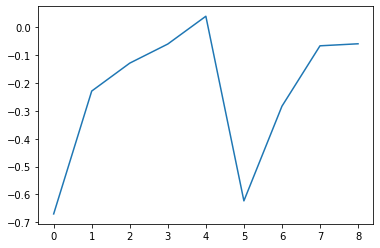

In [79]:
plt.plot(pca1.components_[0])

In [3]:
print('a')

a


In [4]:
import numpy as np
np.random.random((100, 100))

array([[0.33498681, 0.67227731, 0.70734768, ..., 0.22149554, 0.51304006,
        0.14644495],
       [0.74911001, 0.16132654, 0.72621096, ..., 0.49495612, 0.91888637,
        0.38937979],
       [0.67765466, 0.33703214, 0.85189213, ..., 0.74422654, 0.38679313,
        0.09167505],
       ...,
       [0.65646925, 0.01775704, 0.87769535, ..., 0.46708043, 0.08557444,
        0.86769538],
       [0.81740904, 0.86045209, 0.88683459, ..., 0.75798864, 0.49980566,
        0.84358053],
       [0.34499161, 0.44475294, 0.93971324, ..., 0.79398929, 0.18279196,
        0.23164707]])

In [5]:
np.random.random((100, 100))

array([[0.90960808, 0.42738433, 0.72751672, ..., 0.66330792, 0.74307664,
        0.83624505],
       [0.38961738, 0.30912956, 0.36523415, ..., 0.53414965, 0.27273884,
        0.44803481],
       [0.67832103, 0.15567721, 0.05051863, ..., 0.95204893, 0.58346596,
        0.65157511],
       ...,
       [0.02893081, 0.59530758, 0.3086394 , ..., 0.59728704, 0.50871369,
        0.42958867],
       [0.79124426, 0.89368957, 0.6571711 , ..., 0.53719665, 0.04894902,
        0.69344399],
       [0.13565525, 0.33255612, 0.68859349, ..., 0.03315147, 0.19109193,
        0.17937561]])